# Setup

In [3]:
from datetime import datetime, timedelta
import time
import requests
from dotenv import load_dotenv
import os
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from handlers import DataHandler
from news_api import NewsAPI
from useconomyapi import USEconomyAPI
from seekingalpha import SeekingAlphaNewsAPI
from visualizations import Visualizations
from cryptopanic import CryptoPanicAPI
from cryptonewsapi import CryptoNewsAPI
from coinrankingapi import CryptoDataFetcher
from sentiment import SentimentAnalyzer

hd = DataHandler()
vz = Visualizations()
load_dotenv()

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [4]:
#for testing set from_date and time_period based on what you want to show
from_date = 2
if from_date == 2:
    time_period = '30d'
elif from_date == 1:
    time_period = '24h'
else:
    raise ValueError("wrong input")

# Get News Articles

## Getting Past Month News

This code is designed to fetch and process news articles about cryptocurrency from various sources over the past 30 days. It uses three APIs: NewsAPI, USEconomyAPI, and SeekingAlphaNewsAPI. Initially, it retrieves news from NewsAPI within the specified date range and standardizes the date format. If articles are found, it proceeds to fetch news from the USEconomyAPI, converting dates to Unix timestamps for the query. Then, it fetches additional news from SeekingAlphaNewsAPI for the same date range. The data from all three sources are combined into a single DataFrame, and duplicate headlines are processed to ensure uniqueness. Finally, the merged data is prepared for further use or analysis.

In [ ]:
from_date = 30
# Create an instance of the NewsAPI
news_api = NewsAPI(api_key=os.getenv('news_api'))
# Fetch news articles about Crypto from a specific date range
df = news_api.get_news(topic='crypto', from_date=hd.get_date_str(from_date), to_date=(hd.get_date_str(0)))
df = hd.standardize_date_format(df, 'date')

# Check if the DataFrame is not empty
if not df.empty:
    # Print the headlines along with the date and description
    print(f"{len(df)} news found")
else:
    print("No articles found for the given topic and date range.")

api = USEconomyAPI(os.getenv('useconomyapi'))
starting_date = hd.convert_to_unix_ms(hd.get_date_dt(from_date))
ending_date = hd.convert_to_unix_ms(hd.get_date_dt(0))
crypto_news_df_2 = api.fetch_news(category='economy', initial=starting_date, final=ending_date )
crypto_news_df_2 = api.format_news_data(crypto_news_df_2)


api_key = os.getenv('seeking_alpha')
seeking_alpha_api = SeekingAlphaNewsAPI(api_key)
category = 'crypto'
crypto_news_df_3 = seeking_alpha_api.fetch_news_by_days(from_date, category)

## Getting Daily News

This code fetches daily news articles about cryptocurrency from multiple sources and processes the data to remove duplicates. It initializes the CryptoPanicAPI with an authentication token and fetches "hot" public news posts. The fetched data is formatted into a DataFrame. Next, it uses CryptoNewsAPI to gather news from specific sources like Coindesk and Cointelegraph, formatting and appending the data to a list. If the list is not empty, the data is concatenated into a single DataFrame. The code then fetches and formats additional news from USEconomyAPI and SeekingAlphaNewsAPI for the same date range. All gathered data is merged into a single DataFrame, and duplicates are processed to ensure uniqueness. The final DataFrame contains a comprehensive set of cryptocurrency news for the day, ready for further use or analysis.

In [ ]:
from_date = 1
auth_token = os.getenv('cryptopanic')  # Example token
crypto_panic_api = CryptoPanicAPI(auth_token)
filters = {
    'public': 'true',
    'filter': 'hot',
    'currencies': None
}
df = crypto_panic_api.format_news_data(crypto_panic_api.fetch_news(filters))

api_key = os.getenv('cryptonewsapi')
crypto_news_api = CryptoNewsAPI(api_key)
sources = ['coindesk', 'cointelegraph', 'bitcoinist', 'decrypt', 'bsc', 'theguardian']
all_news = []  # List to store data from each source
for source in sources:
    news_data = crypto_news_api.fetch_news(source) 
    if news_data:  # Ensure there is data before formatting
        formatted_data = crypto_news_api.format_news_data(news_data)
        if not formatted_data.empty:
            all_news.append(formatted_data)  # Append the formatted DataFrame to the list
# Concatenate all dataframes if all_news is not empty
if all_news:
    df_daily_news_2 = pd.concat(all_news)
    df = pd.concat([df,df_daily_news_2])

api = USEconomyAPI(os.getenv('useconomyapi'))
starting_date = hd.convert_to_unix_ms(hd.get_date_dt(from_date))
ending_date = hd.convert_to_unix_ms(hd.get_date_dt(0))
crypto_news_df_2 = api.fetch_news(category='economy', initial=starting_date, final=ending_date )
crypto_news_df_2 = api.format_news_data(crypto_news_df_2)

api_key = os.getenv('seeking_alpha')
seeking_alpha_api = SeekingAlphaNewsAPI(api_key)
crypto_news_df_3 = seeking_alpha_api.fetch_news_by_days(from_date, 'crypto')

## Process Data

Here we concatenate the news dataset from the various APIs and process the duplicates.

In [ ]:
# for testing purposes Load data
#crypto_news_df = pd.read_csv('data/crypto_30d_news.csv')
#crypto_news_df_2 = pd.read_csv('data/crypto_30d_news_2.csv')
#us_economy_news = pd.read_csv('data/us_economy_30d_news.csv')

In [5]:
# Merge the dataframes
df = pd.concat([df, crypto_news_df_2, crypto_news_df_3])
hd.process_duplicates(df)

Duplicate Entries: 0


In [ ]:
#for testing purposes
df.to_csv(f'data/{from_date}d_news.csv', index=False)

# Get Crypto Information

This code fetches historical price data for meme category cryptocurrencies over the past 30 days or 24 hours, based on the value of from_date. It initializes a CryptoDataFetcher with the appropriate API key and time period, then retrieves the price history for relevant cryptocurrencies using the Coinranking API. If data is successfully fetched, it writes the data to a CSV file. The DataHandler class, also included in the code, provides utility functions for handling dates and processing duplicates, though it is not directly used in the main workflow of this script. The CryptoDataFetcher class contains methods for sending API requests, fetching coin UUIDs based on tags, retrieving historical price data, and writing the results to a CSV file.

In [ ]:
category = 'meme'

api_key = os.getenv('coinranking') 

if from_date == 30:
    time_period = '30d'
else:
    time_period = '24h'

fetcher = CryptoDataFetcher(api_key, default_tags=category, default_limit=50, default_time_period=f"{time_period}")
price_data = fetcher.fetch_all_history()

if not price_data.empty:
    fetcher.write_to_csv(price_data, f'data/{time_period}_{fetcher.default_limit}{category}_history.csv')
else:
    print("No data fetched.")

In [17]:
#for testing purposes
df.to_csv(f'data/{time_period}_news.csv', index=False) #for testing

# Sentiment

## Apply Finbert


This code performs sentiment analysis on a DataFrame of text data using a pretrained BERT model. It initializes a SentimentAnalyzer class that uses the ProsusAI/finbert model for financial sentiment analysis. The predict_sentiment_batch method processes text in batches, tokenizes the input texts, and uses the model to predict sentiment scores, utilizing GPU if available. The `add_sentiments_to_df` method adds these sentiment scores as a new column in the input DataFrame. Finally, the script demonstrates using this functionality to add sentiment data to an existing DataFrame and display the first few rows of the augmented DataFrame.

In [ ]:
#for testing purposes
#df = pd.read_csv("data/30d_news.csv")

In [6]:
# Initialize SentimentAnalyzer
analyzer = SentimentAnalyzer()
sentiment_data = analyzer.add_sentiments_to_df(df)
sentiment_data.head()

In [8]:
#for testing purposes
df.to_csv(f'data/{time_period}_news_with_sentiment.csv', index=False)

# Vizualisations


This code visualizes the relationship between cryptocurrency prices and sentiment data. It uses a Visualizations class to process and plot the data. Initially, it averages sentiment scores over specified time periods and normalizes and aggregates cryptocurrency price data across different coins. The plot_normalized_price_and_sentiment method creates a plot showing normalized prices and smoothed sentiment scores over time. The analysis method performs correlation analysis between sentiment and future price changes, plotting the results and calculating statistical measures like correlation coefficients, R-squared values, and AIC. This analysis is visualized through scatter plots and regression lines, highlighting the predictive power of sentiment on price changes. Additionally, plot_for_web and analysis_for_web methods generate similar visualizations optimized for web embedding, returning results as SVG strings. This comprehensive visualization and analysis framework helps to understand how sentiment affects cryptocurrency prices.

## Average Sentiment per Day and Normalize Price

In [18]:
#for testing purposes
if from_date == 2 or from_date == 30:
    sentiment_data = pd.read_csv(f"data/30d_news_with_sentiment.csv")
    price_data = pd.read_csv('data/30d_50meme_history.csv')
elif from_date == 1:
    sentiment_data = pd.read_csv(f"data/24h_news_with_sentiment.csv")
    price_data = pd.read_csv('data/24h_50meme_history.csv')
else:
    raise ValueError("from_date should be either 1 (daily) or 30 (monthly).")

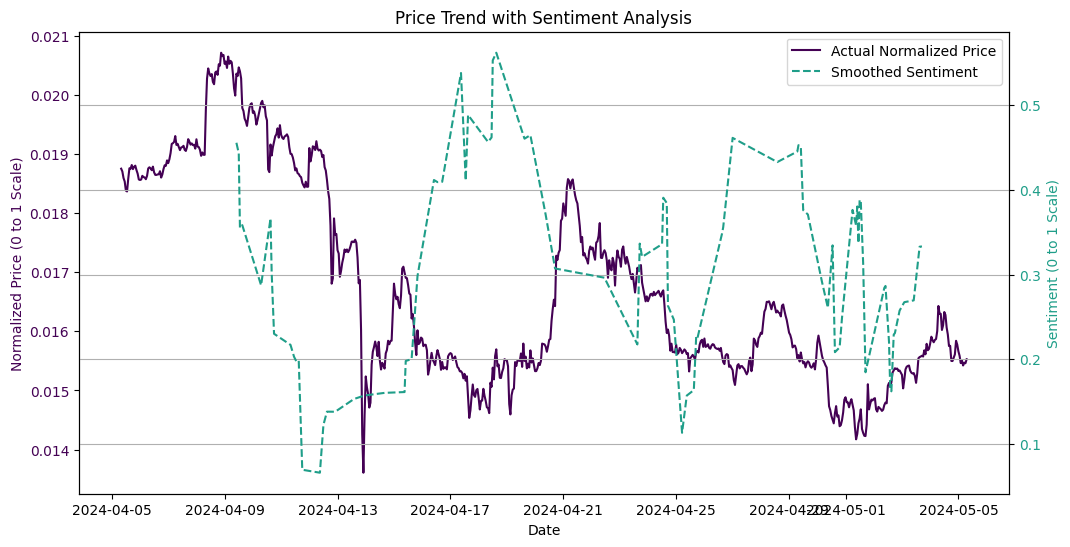

In [12]:
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)

In [13]:
sentiment_data.head()

,average sentiment
date,
2024-04-05 10:00:00,0.219927
2024-04-05 15:00:00,0.783000
2024-04-05 17:00:00,0.029471
2024-04-08 07:00:00,0.514828
2024-04-08 15:00:00,0.383531


In [14]:
price_data.head()

,normalized price
timestamp,
2024-04-05 08:00:00,0.018751
2024-04-05 09:00:00,0.018704
2024-04-05 10:00:00,0.018592
2024-04-05 11:00:00,0.018534
2024-04-05 12:00:00,0.018380


# Analysis 1d

This code processes and combines cryptocurrency price data with sentiment data to facilitate time-series analysis. It starts by calculating the percentage price change from normalized prices and handling any NaN values by replacing them with zero. The price data is then resampled to 5-minute intervals, using forward filling to propagate the last known prices and changes. The sentiment data timestamps are rounded to the nearest 5 minutes to align with the price data intervals.

The code uses the merge_asof function to merge the sentiment data with the nearest corresponding price data, ensuring alignment based on time. To prepare for predictive analysis, it shifts the 'price_change' column by -1 to represent the next 5-minute price change. The combined data is then cleaned up by renaming columns to match expected function inputs and dropping unnecessary columns, resulting in a DataFrame that combines sentiment and future price change data, ready for further analysis.

In [9]:
# Calculate percentage price change directly from normalized prices
price_data['price_change'] = price_data['normalized price'].pct_change() * 100
price_data['price_change'] = price_data['price_change'].fillna(0)  # Replace NaN values with 0

# Resample price data to 5-minute intervals, forward filling the last known prices and changes
price_data_resampled = price_data.resample('5min').last().ffill()

# Round sentiment data timestamps to the nearest 5 minutes
sentiment_data.index = sentiment_data.index.round('5min')

# Merge using merge_asof to align sentiment data with the nearest price data
combined_data = pd.merge_asof(sentiment_data.sort_index(), price_data_resampled.reset_index(), 
                              left_index=True, right_on='timestamp', direction='forward')

# Since we need the next period's price change, shift the 'price_change' column by -1
combined_data['Next 5min Price Change'] = combined_data['price_change'].shift(-1)

# Rename columns to match function expectations
combined_data.rename(columns={'Average Sentiment': 'Average Sentiment'}, inplace=True)

# Drop the 'timestamp' and original 'price_change' columns if not needed
combined_data.drop(columns=['timestamp', 'price_change'], inplace=True)

combined_data.head()

,average sentiment,normalized price,Next 5min Price Change
date,,,
2024-04-05 10:00:00,0.219927,0.018592,0.962161
2024-04-05 15:00:00,0.783000,0.018758,0.335842
2024-04-05 17:00:00,0.029471,0.018813,-0.007174
2024-04-08 07:00:00,0.514828,0.018985,-0.187314
2024-04-08 15:00:00,0.383531,0.020179,-0.616799


This code uses the Visualizations class to analyze the relationship between cryptocurrency price changes and sentiment data over different time periods. The analysis method is invoked with combined data and a specified date range (from_date). Depending on the from_date value (1 for daily or 30 for monthly), it sets the time intervals and lags for analysis.

For each specified lag, the method:

1. Shifts the sentiment data by the lag value to create a "Lagged Sentiment" column.
2. Calculates the correlation between lagged sentiment and the next period's price change.
3. Plots scatter plots showing the relationship between lagged sentiment and future price changes.
4. Computes and prints statistical metrics, including average price changes for high and low sentiment, correlation coefficients, R-squared values, and AIC.

The method also performs linear regression analysis to determine the predictive power of sentiment on price changes. If from_date is 30, it additionally resamples the data for longer-term analysis. The results are visualized using scatter plots with regression lines, and a summary of correlations is displayed using a bar plot. This comprehensive analysis helps in understanding how sentiment impacts cryptocurrency prices over different time lags.

In [ ]:
vz.analysis(combined_data, from_date)

# Analysis 30d

To address how the price change is calculated and ensure accuracy, let's clarify the method. The price change between two days is typically calculated using the formula:

Price Change (%) = ((Current Day Price−Previous Day Price) / Previous Day Price ) × 100

This formula captures the percentage change from one day to the next, which is ideal for analyzing how daily variations in price relate to other factors like sentiment.

Analyse how the variable Average Sentiment of a day influence the variable Price change.

In [15]:
# Get the closing price for each day (last price of the day)
price_data_daily = price_data['normalized price'].resample('D').last()

# Calculate the daily price change percentage
price_data_daily = pd.DataFrame(price_data_daily)  # Ensure it's a DataFrame for the next operations
price_data_daily['Price Change'] = price_data_daily['normalized price'].pct_change() * 100

# Shift the price change to align with the day's sentiment to measure its influence on the next day's price change
price_data_daily['Price Change'] = price_data_daily['Price Change'].shift(-1)

# Since sentiment is often recorded multiple times a day, we'll average it for daily granularity
sentiment_data_daily = pd.DataFrame(sentiment_data['average sentiment'].resample('D').mean())

# Merge the two datasets on the date index
combined_data = pd.concat([price_data_daily, sentiment_data_daily], axis=1)
combined_data.columns = ['Normalized Price', 'Next Day Price Change', 'average sentiment']
combined_data.dropna(inplace=True)  # Drop rows with NaN values that might result from resampling, shifting, or non-overlapping dates

### Lag Analysis
Shift the sentiment data by various time periods (both forward and backward) to see if the correlation improves when assuming a delayed effect of sentiment on prices.
Experiment with different lags between sentiment data and price data. Often, market reactions to news or events are not immediate. Analyzing the effect of sentiment over different time lags (e.g., 1 day, 2 days, 1 week) might reveal stronger correlations.

- **Lagging Sentiment Data Backward (Negative Lag)**
Concept: When we lag sentiment data backward (using a negative lag), we are effectively shifting sentiment data to later dates. This method is used when you suspect that sentiment influences future price changes. For example, if we use a lag of -1 day, the sentiment data from January 1st is aligned with the price change of January 2nd. This is based on the hypothesis that today's sentiment will affect tomorrow's price changes.
This approach is suitable if we are testing the hypothesis that the market reacts to sentiment after a delay. It helps to identify if changes in sentiment can predict subsequent movements in prices.
- **Lagging Sentiment Data Forward (Positive Lag)**
Concept: Lagging sentiment data forward (using a positive lag) means we shift sentiment data to earlier dates. This scenario is used to examine if past sentiment changes are reflected in current or future price changes. For instance, if we set a lag of +1 day, the sentiment from January 2nd is used in conjunction with the price change of January 1st. This might seem counterintuitive at first, as it suggests looking at how previous price changes correlate with future sentiment but can be insightful for retrospective analyses, such as studying whether price changes lead to a detectable shift in sentiment, perhaps due to investor reactions or feedback loops in market behavior.

#### Procedure
- **Plotting Correlation**
Plotting sentiment against price change can help visually identify patterns or trends, such as whether lower sentiments tend to coincide with negative price changes.
- **Descriptive Statistics**
 Compute and compare averages or percent changes across different conditions. For example, comparing average price changes on days with particularly high or low sentiments.
 - **Daily Regression Analysis**
We could use regression techniques  to see how changes in sentiment predict changes in price.
- **Weekly Regression Analysis**
As daily correlation might not provide the best results, we could use regression techniques over a period (e.g., weekly, monthly) to see how changes in sentiment predict changes in price.

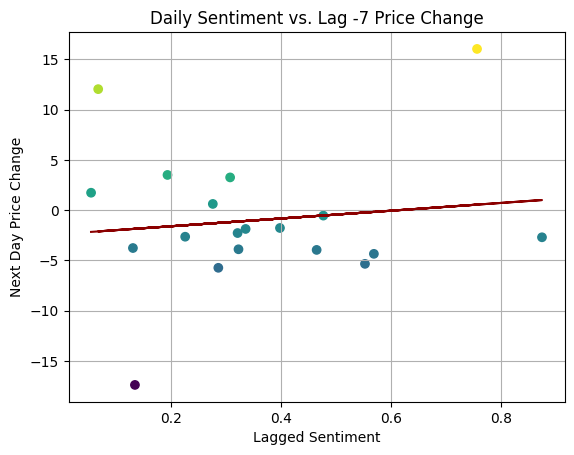

Correlation with -7 Day(s) lag: 0.12
Linear Model R-squared: 0.02
Linear Model RMSE: 6.69

Average Price Change on High Sentiment Days: -124 %
Average Price Change on Low Sentiment Days: -78 %


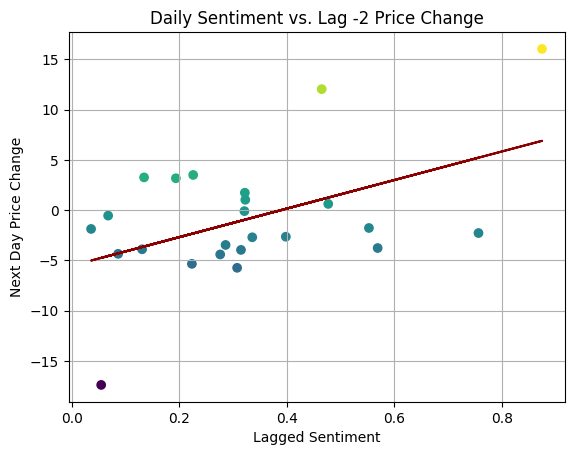

Correlation with -2 Day(s) lag: 0.48
Linear Model R-squared: 0.23
Linear Model RMSE: 5.37

Average Price Change on High Sentiment Days: -136 %
Average Price Change on Low Sentiment Days: -53 %


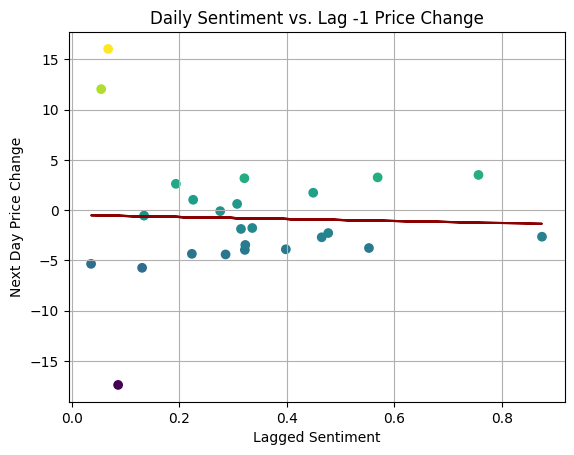

Correlation with -1 Day(s) lag: -0.03
Linear Model R-squared: 0.0
Linear Model RMSE: 6.05

Average Price Change on High Sentiment Days: -136 %
Average Price Change on Low Sentiment Days: -29 %


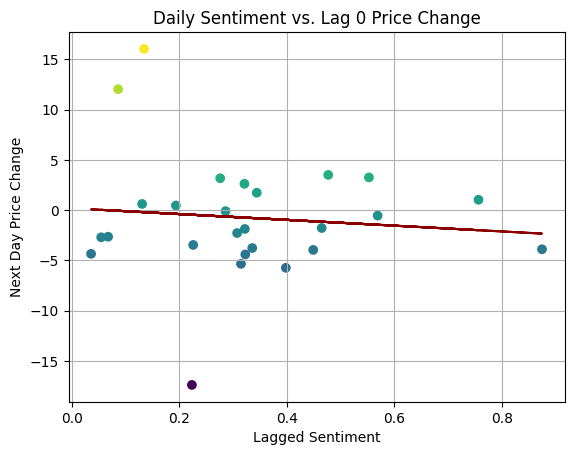

Correlation with 0 Day(s) lag: -0.1
Linear Model R-squared: 0.01
Linear Model RMSE: 5.91

Average Price Change on High Sentiment Days: -106 %
Average Price Change on Low Sentiment Days: -45 %


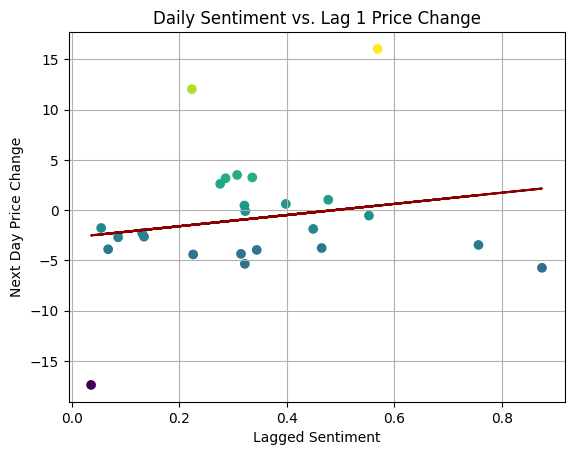

Correlation with 1 Day(s) lag: 0.19
Linear Model R-squared: 0.04
Linear Model RMSE: 5.93

Average Price Change on High Sentiment Days: -129 %
Average Price Change on Low Sentiment Days: -45 %


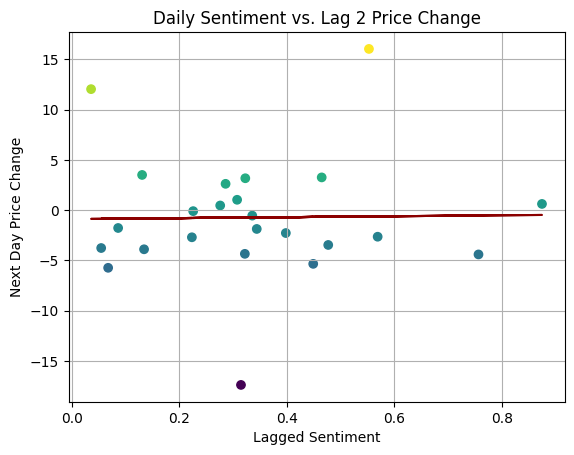

Correlation with 2 Day(s) lag: 0.02
Linear Model R-squared: 0.0
Linear Model RMSE: 6.12

Average Price Change on High Sentiment Days: -141 %
Average Price Change on Low Sentiment Days: -4 %


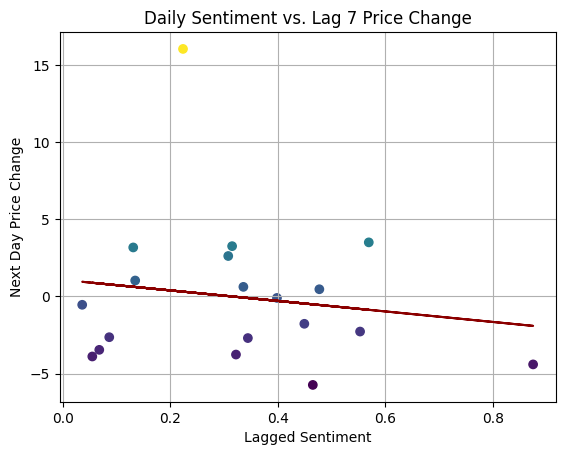

Correlation with 7 Day(s) lag: -0.15
Linear Model R-squared: 0.02
Linear Model RMSE: 4.62

Average Price Change on High Sentiment Days: -137 %
Average Price Change on Low Sentiment Days: 118 %


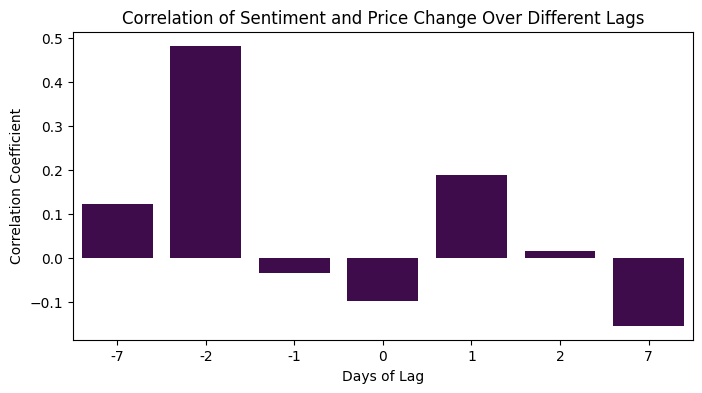

In [23]:
# Perform Analysis
model_type = 'linear'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

In [26]:
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

Average Prediction for lag 0: N/A
Average Prediction for lag 1: -1.78
Average Prediction for lag 2: -0.75
Average Prediction for lag 3: -0.62
Average Prediction for lag 4: -1.03
Average Prediction for lag 5: -0.74
Average Prediction for lag 6: N/A
Overall Average Prediction across all lags: -0.98


After observing suboptimal results from the previous linear regression model, we decided to employ a random forest model to leverage its strengths in capturing complex, non-linear relationships between sentiment and cryptocurrency price changes. The choice of n_estimators=1000 was made to ensure a robust and stable model by averaging the results of a large number of decision trees, which helps to reduce overfitting and improve predictive accuracy. The specific value of 1000 strikes a balance between achieving these benefits and managing computational efficiency. We set random_state=42 to ensure reproducibility of our results, facilitating consistent evaluation and debugging. No other hyperparameters were tuned at this stage to maintain simplicity and focus on the primary adjustments. Further tuning can be explored if the model's performance needs additional improvements after initial evaluation.

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:176: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


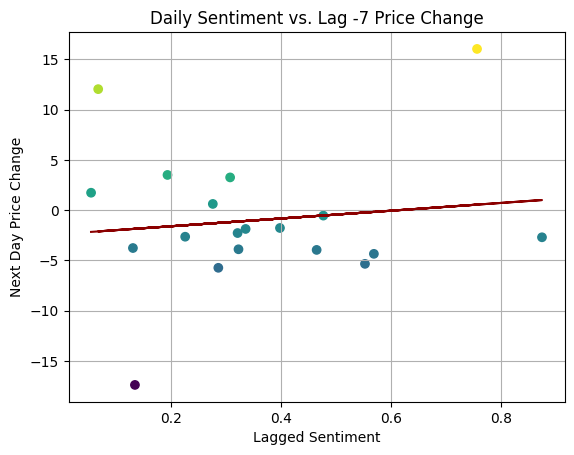

Correlation with -7 Day(s) lag: 0.12
Rf Model R-squared: 0.81
Rf Model RMSE: 2.94

Average Price Change on High Sentiment Days: -124 %
Average Price Change on Low Sentiment Days: -78 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:176: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


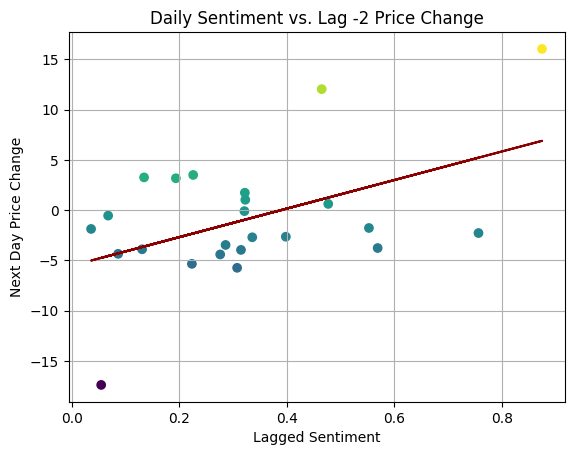

Correlation with -2 Day(s) lag: 0.48
Rf Model R-squared: 0.79
Rf Model RMSE: 2.79

Average Price Change on High Sentiment Days: -136 %
Average Price Change on Low Sentiment Days: -53 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:176: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


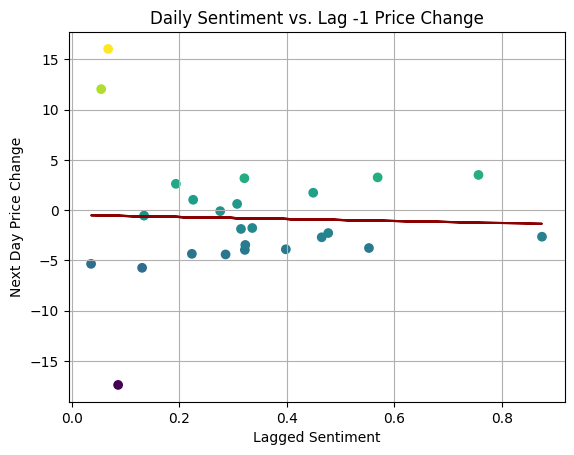

Correlation with -1 Day(s) lag: -0.03
Rf Model R-squared: 0.75
Rf Model RMSE: 3.02

Average Price Change on High Sentiment Days: -136 %
Average Price Change on Low Sentiment Days: -29 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:176: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


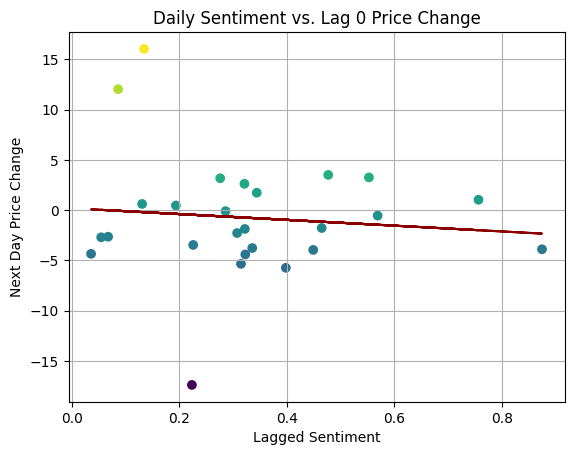

Correlation with 0 Day(s) lag: -0.1
Rf Model R-squared: 0.83
Rf Model RMSE: 2.46

Average Price Change on High Sentiment Days: -106 %
Average Price Change on Low Sentiment Days: -45 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:176: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


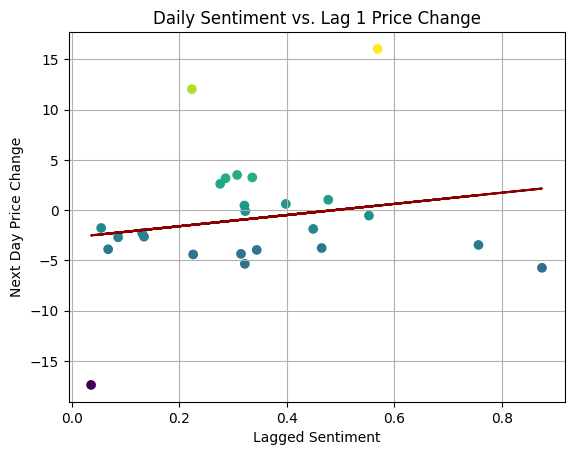

Correlation with 1 Day(s) lag: 0.19
Rf Model R-squared: 0.81
Rf Model RMSE: 2.62

Average Price Change on High Sentiment Days: -129 %
Average Price Change on Low Sentiment Days: -45 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:176: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


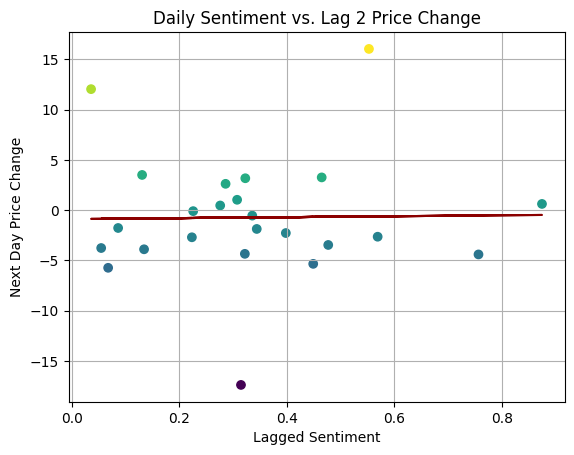

Correlation with 2 Day(s) lag: 0.02
Rf Model R-squared: 0.78
Rf Model RMSE: 2.89

Average Price Change on High Sentiment Days: -141 %
Average Price Change on Low Sentiment Days: -4 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:176: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


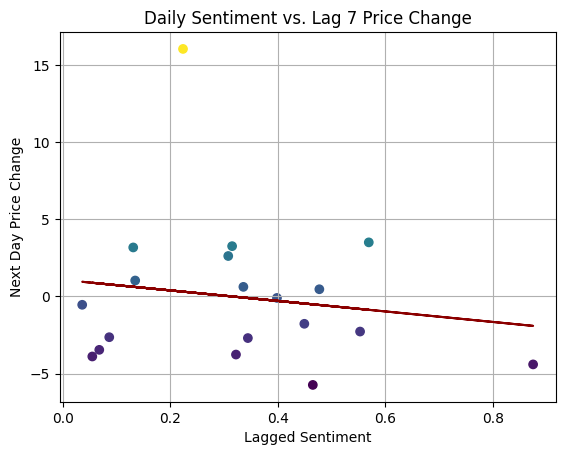

Correlation with 7 Day(s) lag: -0.15
Rf Model R-squared: 0.86
Rf Model RMSE: 1.78

Average Price Change on High Sentiment Days: -137 %
Average Price Change on Low Sentiment Days: 118 %


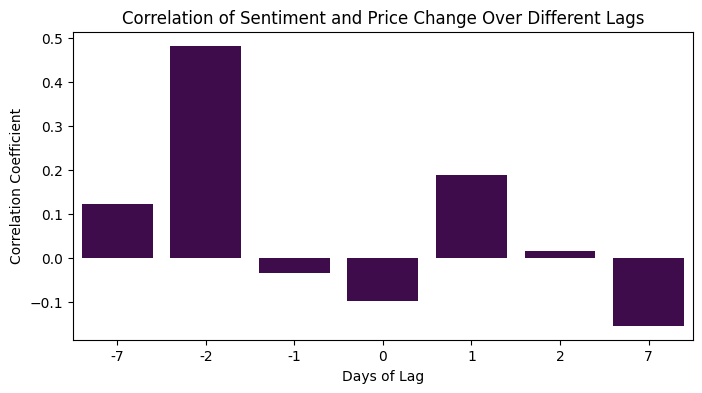

In [28]:
# Perform Analysis
model_type = 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

In [29]:
# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

Average Prediction for lag 0: -2.48
Average Prediction for lag 1: -0.07
Average Prediction for lag 2: -0.37
Average Prediction for lag 3: -0.84
Average Prediction for lag 4: 0.39
Average Prediction for lag 5: -0.13
Average Prediction for lag 6: -0.95
Overall Average Prediction across all lags: -0.64


### Enhancement
1. Volatility and Outliers: If either the price data or the sentiment data is more volatile or has outliers, it can skew the correlation. For example, a few large jumps or drops in price might not be directly linked to sentiment but could still heavily influence the correlation calculation.
3. Noise in Data: The sentiment scores might contain noise due to the inherent subjectivity and complexity of natural language processing. This noise can dilute real correlations with price movements.
4. Non-linear Relationships: The relationship between sentiment and prices might be non-linear, meaning that while they do move together, the relationship might not be directly proportional or consistent across the whole range of data.
5. Averaging and Smoothing: Both the averaging of sentiment over time and the smoothing could be masking more nuanced interactions between individual spikes in sentiment and corresponding price changes.